Code to predict infrared fluxes of 433 Eros with Neural Network

Developer: Saverio Cambioni

Created on: 01/10/2025
Updated on: 06/02/2025

In [21]:
# Validated with packages:
#json==2.0.9
#numpy==1.26.4
#pandas==2.2.3
#tensorflow==2.19.0
#keras==3.9.0
#ipywidgets==7.8.1
#xarray==2023.6.0
#sklearn==1.5.1
#scipy==1.13.1

import numpy as np
import matplotlib.pyplot as plt
import keras
import sklearn.preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import scipy
import pickle

folderNN = 'saved_model' # This subfolder must be in the folder where you are calling the neural networks

def Eros_MLTPM(Epoch, wavelength, Gamma, theta):

    # Function to evaluate neural networks for Eros' analysis saved in "saved_model" folder
    #
    # Inputs are:
    # - Epoch: one of the unique 22 epochs in LUT20250508.txt, float
    # - Wavelength: Nx1 array of wavelengths in microns
    # - Gamma: Nx1 array of thermal inertia in J m-2 s-1/2 k-1
    # - Theta: Nx1 array of hapke angle in degrees
    # 
    # Outputs are:
    #
    # - Flux: Nx1 array of flux predictions in Jy
    #
    # Note 1: Wavelength, Gamma and Theta must be between their min and max values in LUT20250508
    # Note 2: Wavelength, Gamma and Theta must be single-value floats or array of the same length

    # Load the model
    model = keras.models.load_model(folderNN+'/NN_'+str(Epoch)+'.keras')
    with open(folderNN+r"/scaler_in_"+str(Epoch)+".pkl", "rb") as input_file:
        scaler = pickle.load(input_file)

    # Prepare the input array

    if isinstance(wavelength, float) or isinstance(wavelength, int): # inputs are not arrays
        
        X_input = np.vstack([[Gamma,theta,wavelength],[Gamma,theta,wavelength]]) 

        # Predict the flux
        Flux = model.predict(scaler.transform(X_input),verbose = 0)[0][0].flatten()

    else: # inputs are all arrays

        X_input = np.vstack([[Gamma,theta,wavelength]]).T
        # Predict the flux
        Flux = model.predict(scaler.transform(X_input),verbose = 0).flatten()

    return Flux

print('Current versions of packages:')
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

Current versions of packages:
json==2.0.9
numpy==1.26.4
pandas==2.2.3
tensorflow==2.19.0
keras==3.9.0
ipywidgets==7.8.1
xarray==2023.6.0
pandas==2.2.3
numpy==1.26.4
keras==3.9.0
sklearn==1.5.1
scipy==1.13.1


Example 1: Simple run of the networks

In [4]:
Epoch = 2450991.767627034

# Scalar case
Gamma = 50 # example of a thermal inertia value, in tiu, at which we want to evaluate the networks
theta = 26.7 # example of a rougheness value, in units of hapke angle thetabar
wavelength = 10.0 # wavelength, um

print('Scalar case: Flux (Jy)', Eros_MLTPM(Epoch, wavelength, Gamma, theta))

# Array array
Gamma = 50 # example of a thermal inertia value, in tiu, at which we want to evaluate the networks
theta = 26.7 # example of a rougheness value, in units of hapke angle thetabar
wavelength = np.linspace(8,15,5) # wavelength, um

print('Scalar case: Flux (Jy)', Eros_MLTPM(Epoch, wavelength, Gamma*np.ones(len(wavelength)), theta*np.ones(len(wavelength))))
print('\n')


Scalar case: Flux (Jy) [4.610716]
Scalar case: Flux (Jy) [2.7000284 4.393987  5.7579904 6.720677  7.6079426]




Example 2: Prediction of networks for all epochs and wavelengths in LUT 20250507 for a given thermal inertia and gamma

/var/folders/fq/mkwrzl8n61s8zxph4sk6rmr80000gn/T/ipykernel_72946/2017999286.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', 22)


(5.0, 50.0, 0.0, 3.0)

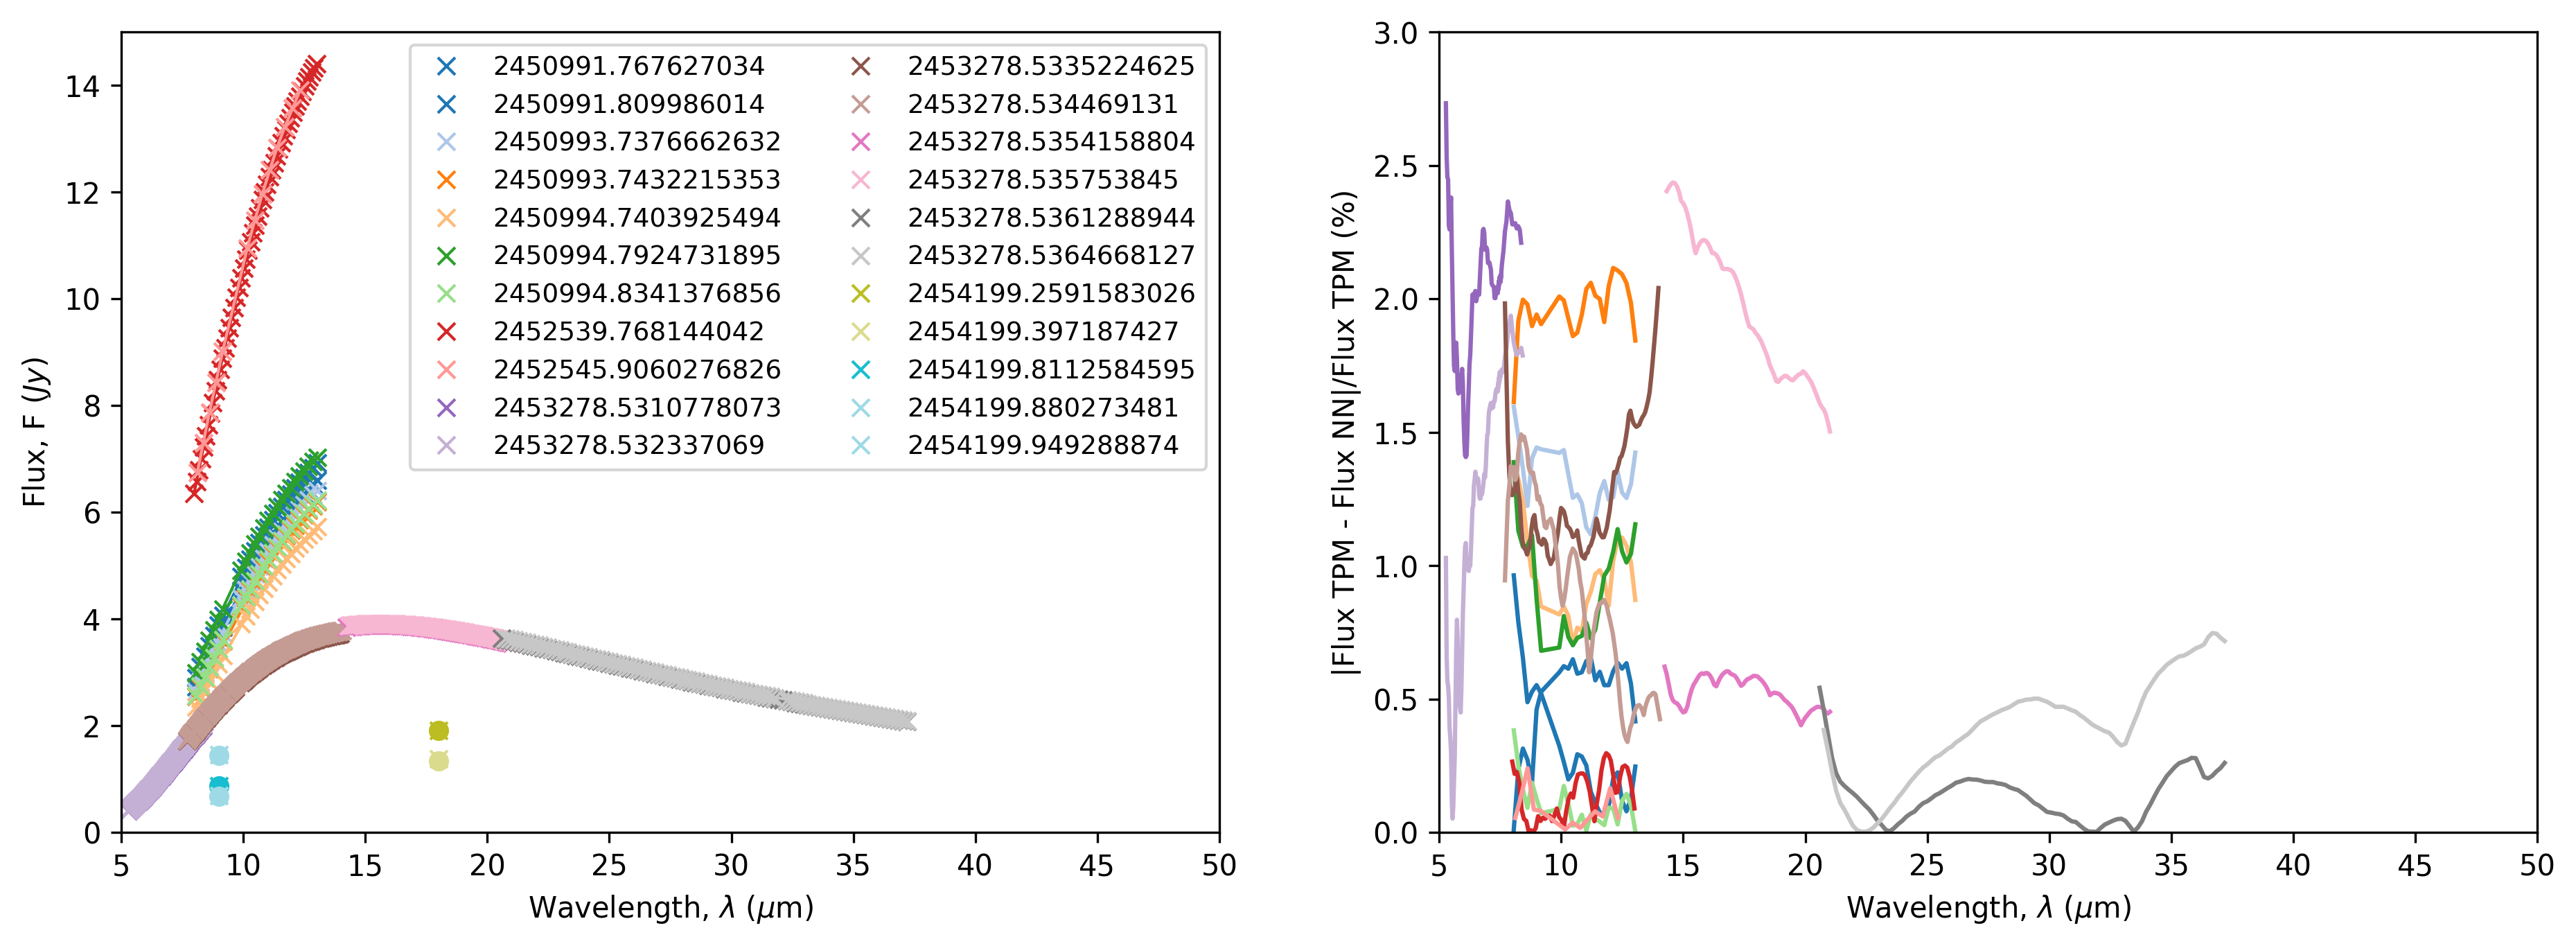

In [64]:
Gamma = 50 # example of a thermal inertia value, in tiu, at which we want to evaluate the networks
theta = 26.7 # example of a rougheness value, in units of hapke angle thetabar

TPM_sims = np.loadtxt('lut_20250508.txt',delimiter = ',')
epoch_unique_array = np.unique(TPM_sims[:,5])

# Generate list of colors 
cmap = plt.cm.get_cmap('tab20', 22)
colors = cmap.colors  # this method is not applicable to LinearSegmentedColormaps
#colors = cmap(range(len(epoch_unique_array)))
#colors = cmap(np.linspace(0, 1, len(epoch_unique_array)))

fig, ax = plt.subplots(1,2,figsize = (15,5),dpi = 300)
for i in range(len(epoch_unique_array)):

    # Get only the entries at the epoch
    dist = np.abs(TPM_sims[:,5]-epoch_unique_array[i])
    idx1 = np.where(dist<1e-8)

    # Get only the entries corresponding to a specific 
    TPM_sims_epoch = TPM_sims[idx1[0],:]
    idx2 = np.where(np.logical_and(TPM_sims_epoch[:,0]==50,TPM_sims_epoch[:,1]==26.7))[0]
    
    wavelength_array = TPM_sims_epoch[idx2,6]
    gamma_array = TPM_sims_epoch[idx2,0]
    theta_array = TPM_sims_epoch[idx2,1]

    flux_LUT = TPM_sims_epoch[idx2,7]
    flux_NN = Eros_MLTPM(epoch_unique_array[i], wavelength_array, gamma_array, theta_array)

    if flux_NN.size == 1:
        ax[0].plot(wavelength_array,flux_LUT,'x',color = colors[i,:],label=str(epoch_unique_array[i]))
        ax[0].plot(wavelength_array,flux_NN,'o',color = colors[i,:])
    else:
        ax[0].plot(wavelength_array,flux_LUT,'x',color = colors[i,:],label=str(epoch_unique_array[i]))
        ax[0].plot(wavelength_array,flux_NN,'-',lw = 1,color = colors[i,:])

    ax[1].plot(wavelength_array,np.abs(flux_LUT.flatten()-flux_NN.flatten())/flux_LUT.flatten()*100,'-',color = colors[i,:])

#ax.legend(ncols = 3)
ax[0].set_xlabel(r'Wavelength, $\lambda$ ($\mu$m)')
ax[0].set_ylabel('Flux, F ($Jy$)')
ax[0].axis([5,50,0,15])
ax[0].legend(ncols = 2,fontsize = 9)

ax[1].set_xlabel(r'Wavelength, $\lambda$ ($\mu$m)')
ax[1].set_ylabel('|Flux TPM - Flux NN|/Flux TPM (%)')
ax[1].axis([5,50,0,3])



Example 3: Use neural networks to model the flux of a surface with rocks and regolith for some spectral data

Text(0.5, 1.0, 'Regolith TI: 50 TIU; Rock TI: 1500 TIU; thetabar = 15 deg')

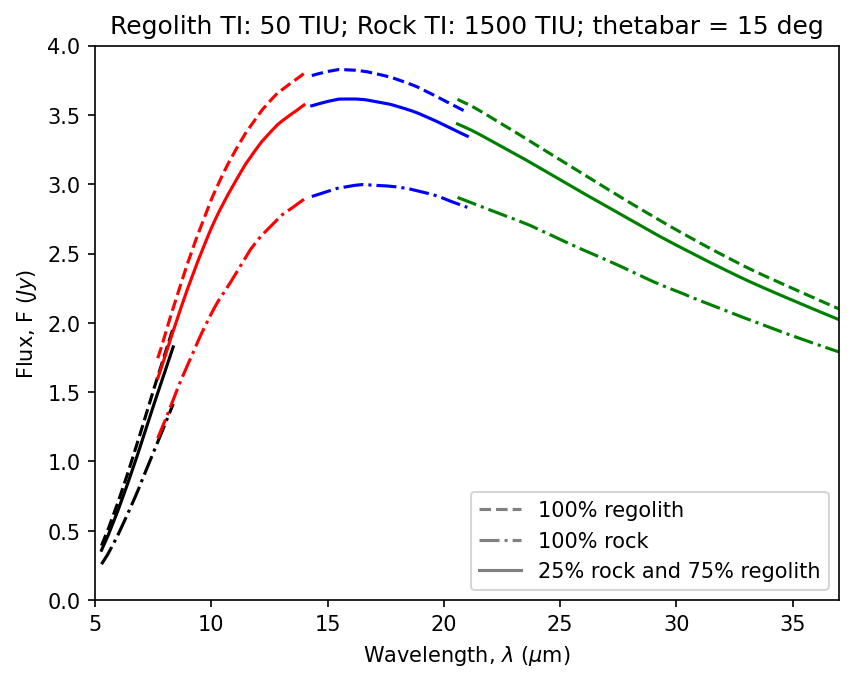

In [84]:
# I just selected some epochs here that cover the entire planck function
epoch_array = np.array([2453278.5310778073, 2453278.5335224625, 2453278.535753845,2453278.5361288944]) 
colors = np.array(['black','red','blue','green'])

fig = plt.figure(dpi = 150)
for i in range(len(epoch_array)):

    # Get only the entries at the epoch
    dist = np.abs(TPM_sims[:,5]-epoch_array[i])
    idx1 = np.where(dist<1e-8)
    TPM_sims_epoch = TPM_sims[idx1[0],:]
    wavelength_array = np.linspace(np.min(TPM_sims_epoch[:,6]),np.max(TPM_sims_epoch[:,6]),1000)

    GammaReg = 50 # tiu, thermal inertia of the regolith, assumed
    GammaRock = 1500 # tiu, thermal inertia of the rock, assumed
    theta = 15 # degrees, hapke angle, assumed
    Epoch = epoch_array[i]#epoch_unique_array[0] #epoch, assumed


    # Single component fluxes
    Flux_regolith = Eros_MLTPM(Epoch, wavelength_array, GammaReg*np.ones(len(wavelength_array)), theta_array*np.ones(len(wavelength_array)))
    Flux_rock = Eros_MLTPM(Epoch, wavelength_array, GammaRock*np.ones(len(wavelength_array)), theta_array*np.ones(len(wavelength_array)))

    # Assuming 25% rocks, we can linearly combine the fluxes of rock and regolith in planck space
    RA = 0.25 # Rock abundance

    Flux = Flux_regolith*(1-RA)+Flux_rock*RA

    plt.plot(wavelength_array,Flux,'-',color =colors[i])
    plt.plot(wavelength_array,Flux_regolith,'--',color =colors[i])
    plt.plot(wavelength_array,Flux_rock,'-.',color =colors[i])
    plt.axis([5,37,0,4])

# Just for legend
plt.plot(wavelength_array,-Flux_regolith,'--',color ='gray',label = '100% regolith')
plt.plot(wavelength_array,-Flux_rock,'-.',color ='gray',label = '100% rock')
plt.plot(wavelength_array,-Flux,'-',color ='gray',label = '25% rock and 75% regolith')
plt.legend()
plt.xlabel(r'Wavelength, $\lambda$ ($\mu$m)')
plt.ylabel('Flux, F ($Jy$)')
plt.title(r'Regolith TI: 50 TIU; Rock TI: 1500 TIU; thetabar = 15 deg')
          

End of code